In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scienceplots
import seaborn as sns
import matplotlib.animation as animation
from scipy.fft import fft, rfft, fftfreq, rfftfreq
from scipy import signal

def get_pos(N, N_e=8):

    pos     = {}
    node    = N_e

    for y in range(N):
        for x in range(N):

            pos[node]   = (x,y)
            node        += 1

    pos[0] = (-1,-1)
    if N % 2 != 0:
        pos[1] = (int(N/2),-1)
    else:
        pos[1] = (int(N/2)-1,-1)
    pos[2] = (N,-1)
    if N % 2 != 0:
        pos[3] = (-1,int(N/2))
    else:
        pos[3] = (-1,int(N/2)-1)
    pos[4] = (-1,N)
    pos[5] = (N,int(N/2))
    pos[6] = (int(N/2),N)
    pos[7] = (N,N)

    return pos

def min_max(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

N_voltages      = 2500
max_time        = 10e-4
sample_rate     = (N_voltages-1)/max_time
time_steps      = np.linspace(0,max_time,N_voltages)
time_steps      = time_steps[1:]
blue_color      = '#4477AA'
red_color       = '#EE6677'

cmeter      = 1/2.54
single_col  = 8.6


# Main

In [2]:
freq    = 0.2
f_str   = "f_"+str(freq)[0]+str(freq)[2]+"_"
f_str

'f_02_'

In [3]:
dfs     = []
n_stat  = 0

for i in range(0,10):
    for j in range(10):

        df_tmp          = pd.read_csv("data/periodic/"+f_str+f"Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        dfs.append(df_tmp)
        n_stat += 1

df          = sum(dfs)/len(dfs)
test        = pd.DataFrame(np.std(np.stack(dfs), axis=0), columns=df.columns)
df['Error'] = test['Current']
df          = df.drop(columns=['Eq_Jumps'])
df['Error'] = df['Error']/np.sqrt(n_stat)
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Jumps,Current,Error
0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70437.67,24.017401,1.408408
1,0.099874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81189.43,24.416942,1.381492
2,0.099495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91919.50,28.216367,1.201871
3,0.098864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102517.65,27.616791,1.386295
4,0.097984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112956.27,25.667131,1.319083
...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.096856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13496005.93,27.016513,1.241905
2495,0.097984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13506471.15,29.041608,1.346268
2496,0.098864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13517040.19,25.791384,1.260475
2497,0.099495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13527756.91,26.417044,1.272029


## I-O dependency

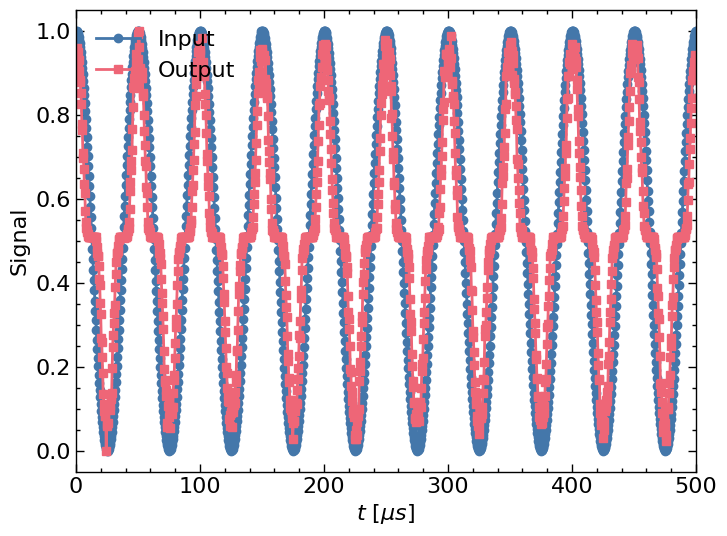

In [4]:
with plt.style.context(['science', 'bright', 'notebook']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, min_max(df['E0']), '-o', color=blue_color, label='Input')
    ax1.plot(time_steps*10**6, min_max(df['Current']), '-s', color=red_color, label='Output')
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('Signal')
    ax1.set_xlim(0,500)
    ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    fig.savefig(f"plots/"+f_str+"I_O_periodic_signal.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/"+f_str+"I_O_periodic_signal.pdf", bbox_inches='tight', transparent=False)
plt.show()

## Frequency

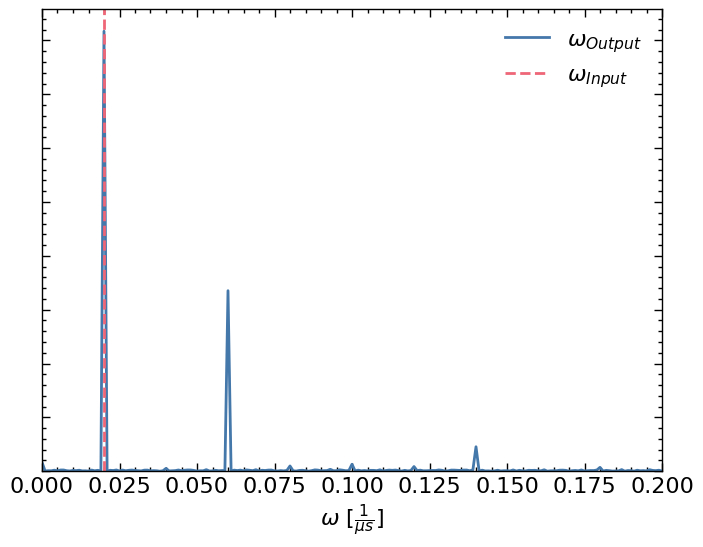

In [5]:
signal  = np.int16((df['Current'].values / df['Current'].values.max()) * 32767)
signal  = df['Current'].values
input_f = freq*(1e5)/10**6

with plt.style.context(['science', 'bright', 'notebook']):

    yf  = rfft(signal)
    xf  = rfftfreq(N_voltages-1, 1 / sample_rate)
    fig = plt.figure()
    ax  = fig.add_subplot()

    ax.plot(xf/10**6, 2*np.abs(yf)/len(signal), label="$\omega_{Output}$")
    ax.axvline(input_f, color=red_color, ls='--', label="$\omega_{Input}$")
    # ax.axvline(input_f, color=red_color, ls='--', label="$\omega_{Input}$")
    ax.set_xlabel("$\omega$ [$\\frac{1}{\mu s}$]")
    ax.set_ylim(0)
    ax.set_yticklabels('')
    ax.set_xlim(0,0.2)
    ax.legend()
    
    fig.savefig(f"plots/"+f_str+"FFT_periodic_signal.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/"+f_str+"FFT_periodic_signal.pdf", bbox_inches='tight', transparent=False)

plt.show()

## combined

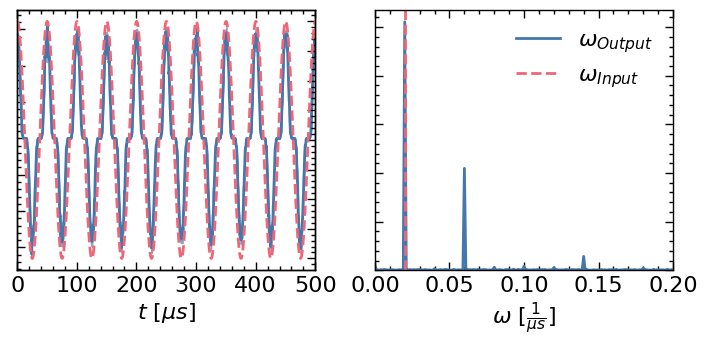

In [6]:
signal  = np.int16((df['Current'].values / df['Current'].values.max()) * 32767)
signal  = df['Current'].values
input_f = freq*(1e5)/10**6

with plt.style.context(['science', 'bright', 'notebook']):

    fig = plt.figure()
    fig.set_figwidth(2.5*single_col*cmeter)
    fig.set_figheight(single_col*cmeter/1)

    ax1 = fig.add_subplot(1,2,1)
    ax2 = ax1.twinx()
    ax1.plot(time_steps*10**6, df['Current'].values, '-', color=blue_color, label='$I$')
    ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=blue_color, alpha=.6)
    ax2.plot(time_steps*10**6, df['E0'].values, '--', color=red_color, label='$U_I$')
    ax1.set_xlabel('$t$ [$\mu s$]')
    # ax1.set_ylabel('Signal')
    ax1.set_xlim(0,500)
    ax1.set_yticklabels("")
    ax2.set_yticklabels("")
    # ax1.legend(loc='lower right')

    yf = rfft(signal)
    xf = rfftfreq(N_voltages-1, 1 / sample_rate)

    ax  = fig.add_subplot(1,2,2)
    ax.plot(xf/10**6, np.abs(yf), label="$\omega_{Output}$")
    ax.axvline(input_f, color=red_color, label="$\omega_{Input}$", ls='--')
    ax.set_xlabel("$\omega$ [$\\frac{1}{\mu s}$]")
    ax.set_ylim(0)
    ax.set_xlim(0,0.2)
    ax.legend()
    ax.set_yticklabels("")
    plt.subplots_adjust(wspace=0.2)

    fig.savefig(f"plots/"+f_str+"1_In_1_Out_time_dep.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/"+f_str+"1_In_1_Out_time_dep.pdf", bbox_inches='tight', transparent=False)

plt.show()

## Animtaion

In [7]:
G   = nx.DiGraph()
G.add_nodes_from([i for i in range(49+8)])
G.add_edges_from([eval(i) for i in pd.read_csv(f"data/periodic/"+f_str+"net_currents_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv").columns])
pos             = get_pos(7)
node_color      = np.repeat(blue_color, 49+8)
node_color[0:8] = None
node_labels     = {i:'' for i in range(49+8)}
node_labels[0]  = '$I$'
node_labels[2]  = '$C$'
node_labels[4]  = '$C$'
node_labels[7]  = '$O$'
node_labels[1]  = '$C$'
node_labels[3]  = '$C$'
node_labels[5]  = '$C$'
node_labels[6]  = '$C$'

In [8]:
n_stat  = 1
states  = pd.read_csv(f"data/periodic/"+f_str+"mean_state_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")

for i in range(0,10):
    for j in range(10):
        if not((i == 0) and (j == 0)):
            states += pd.read_csv("data/periodic/"+f_str+f"mean_state_Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
            n_stat += 1
            
states = states/n_stat

MovieWriter ffmpeg unavailable; using Pillow instead.


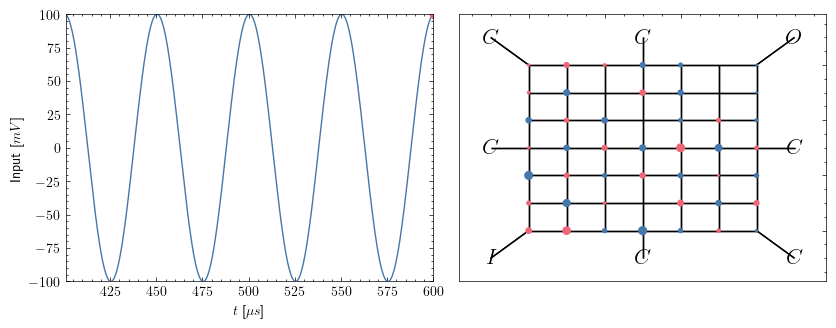

In [10]:
raw_data    = pd.read_csv("data/periodic/"+f_str+"Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

start_ind   = 1500
n_frames    = 500
in_vals     = in_vals[start_ind:start_ind+n_frames]
t_vals      = t_vals[start_ind:start_ind+n_frames]

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    fig.set_figwidth(2.5*single_col*cmeter)
    fig.set_figheight(single_col*cmeter/1)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    def update(row):

        ax1.clear()
        ax1.plot(t_vals, in_vals)
        ax1.plot(t_vals[row], in_vals[row], 'o')
        ax1.set_xlabel('$t$ [$\mu s$]')
        ax1.set_ylabel('Input [$mV$]')
        ax1.set_xlim(np.round(np.min(t_vals)),np.round(np.max(t_vals)))
        ax1.set_ylim(-100,100)

        ax2.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 5000*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax2, node_color=node_colors, arrows=False, labels=node_labels, font_size=16)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.tight_layout()
        # plt.axis('off')
        
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=200, repeat_delay=1000, repeat=True)
    ani.save("plots/gifs/"+f_str+"anim.gif", dpi=500)

plt.show()

### Noise

In [ ]:
noise_data  = {}
n           = 0

for i in range(0,10):

    for j in range(10):

        df_tmp          = pd.read_csv(f"data/noise/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        df_tmp          = df_tmp.drop(columns=['Eq_Jumps', 'Error'])
        noise_data[n]   = df_tmp
        n               += 1

noise_data[0]

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot()

for key,df in noise_data.items():

    ax = df['Current'].plot(ax=ax)

plt.show()

In [ ]:
def memory_cap(x, y):

    x_norm  = x - np.mean(x)
    y_norm  = y - np.mean(y)
    lags    = np.arange(0, len(test_x))
    
    np.roll(x, -lag)-np.mean(x)
    

In [ ]:
ccorr_list = []

for key, df in noise_data.items():
    
    test_x  = df['E0'].values
    test_y  = df['Current'].values
    lags    = np.arange(0, len(test_x))
    x       = test_x - np.mean(test_x)
    y       = test_y - np.mean(test_y)
    ccorr   = [(np.correlate(test_x, np.roll(test_y, -lag)) / (np.linalg.norm(test_x) * np.linalg.norm(test_y)))[0] for lag in lags]
    
    ccorr_list.append(ccorr)

In [ ]:
means   = np.mean(np.array(ccorr_list).T,axis=1)
stds    = np.std(np.array(ccorr_list).T,axis=1)

with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time_steps*10**6, means, '-')
    ax.fill_between(time_steps*10**6, means-stds, means+stds, alpha=0.6)
    # ax.plot(time_steps*10**6, np.mean(np.array(ccorr_list).T,axis=1))
    ax.set_xlabel("$\\tau$ [$\mu s$]")
    ax.set_xlim(0,100)
    ax.set_ylim(0,1)

In [ ]:
with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(np.arange(0,len(test_x)), test_x)
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(test_x),len(test_x)*2), test_y)

In [ ]:
# Sample time series data for x and y
x = np.array([1, 2, 3, 4, 5])
y = np.array([3, 4, 5, 6, 7])

# Calculate the cross-correlation using the normalized cross-correlation formula
cross_corr = [np.correlate(x, np.roll(y, -lag)) / (np.linalg.norm(x) * np.linalg.norm(y)) for lag in range(len(x))]

# Create the lag values
lags = range(len(x))

# Plot the standardized cross-correlation as a function of τ
plt.plot(lags, cross_corr)
plt.xlabel('Time Lag (τ)')
plt.ylabel('Standardized Cross-correlation')
plt.show()

In [ ]:
blue_color          = '#4477AA'
red_color           = '#EE6677'

with plt.style.context(["science","nature","bright"]):
    
    fig, ax1    = plt.subplots(dpi=200)
    ax2         = ax1.twinx()

    ax1.errorbar(x=time_steps[:-1]*1000 ,y=df['O'], yerr=df['sO'], c=blue_color)
    ax2.plot(time_steps[:-1]*1000, df['I']*1000, c=red_color)
    ax1.set_xlabel("Time [ms]")
    ax1.set_ylabel("Output [pA]")
    ax2.set_ylabel("Input [mV]")

    ax1.legend(['Output'], loc='lower left')
    ax2.legend(['Input'], loc='lower right')

    ax1.set_ylim(-1500,1500)
    ax2.set_ylim(-50,50)

plt.show()

In [ ]:
with plt.style.context(["science","nature","bright"]):
    
    fig, ax1    = plt.subplots(dpi=200)
    df          = dic[0.5]

    ax1.plot(df['O'], df['I']*1000)
    ax1.set_xlabel("Input [mV]")
    ax1.set_ylabel("Output [pA]")
    plt.show()

# States

In [ ]:
G   = nx.DiGraph()
G.add_nodes_from([i for i in range(49+8)])
G.add_edges_from([eval(i) for i in pd.read_csv(f"data/periodic/net_currents_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv").columns])
pos             = get_pos(7)
node_color      = np.repeat(blue_color, 49+8)
node_color[0:8] = None
node_labels     = {i:'' for i in range(49+8)}
node_labels[0]  = '$I$'
node_labels[2]  = '$C$'
node_labels[4]  = '$C$'
node_labels[7]  = '$O$'
node_labels[1]  = '$C$'
node_labels[3]  = '$C$'
node_labels[5]  = '$C$'
node_labels[6]  = '$C$'

In [ ]:
states = pd.read_csv(f"data/periodic/mean_state_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
states

In [ ]:
s_vals = states.abs()
s_vals = s_vals/np.max(s_vals.max())
s_logs = np.log(s_vals)
s_logs = s_logs - np.min(s_logs.min())
s_logs

In [ ]:
s_flat  = states.values.flatten()
s_flat  = (s_flat - np.min(s_flat))/(np.max(s_flat) - np.min(s_flat))
s_flat  = s_flat.reshape(-1,49)
s_flat

In [51]:
with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    def update(row):
        
        ax.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 500*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax, node_color=node_colors, arrows=False, labels=node_labels, font_size=8)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.axis('off')


    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=200, repeat_delay=1000, repeat=True)
    ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.


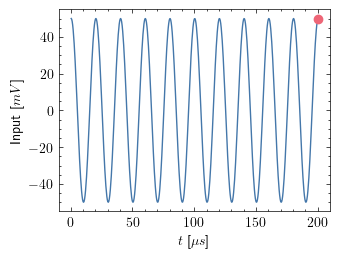

In [55]:
raw_data    = pd.read_csv(f"data/periodic/Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    def update(step):
        ax.clear()
        ax.plot(t_vals, in_vals)
        ax.plot(t_vals[step], in_vals[step], 'o')
        ax.set_xlabel('$t$ [$\mu s$]')
        ax.set_ylabel('Input [$mV$]')
        ax.set_xlim(0,200)
        ax.set_ylim(-50,50)
        
    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=200, repeat_delay=1000, repeat=True)
    ani.save("test2.gif")

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


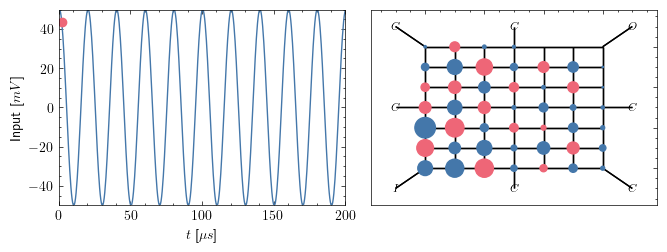

In [61]:
raw_data    = pd.read_csv(f"data/periodic/Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    fig.set_figwidth(2*single_col*cmeter)
    # fig.set_figheight(single_col*cmeter)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    def update(row):

        ax1.clear()
        ax1.plot(t_vals, in_vals)
        ax1.plot(t_vals[row], in_vals[row], 'o')
        ax1.set_xlabel('$t$ [$\mu s$]')
        ax1.set_ylabel('Input [$mV$]')
        ax1.set_xlim(0,200)
        ax1.set_ylim(-50,50)

        ax2.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 500*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax2, node_color=node_colors, arrows=False, labels=node_labels, font_size=8)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.tight_layout()
        # plt.axis('off')
        
    ani = animation.FuncAnimation(fig, update, frames=5, interval=200, repeat_delay=1000, repeat=True)
    ani.save("test.gif")

plt.show()